 # Sentiment Based Product Recommendation System

In [829]:
# importing required packages
import warnings
warnings.filterwarnings('ignore')
import json 
import numpy as np
import pandas as pd
import re, nltk, string
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline
import math
import seaborn as sns
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report,roc_auc_score,make_scorer, plot_confusion_matrix

In [830]:
# importing the data 
reviews_data = pd.read_csv("Sample30.csv")

In [831]:
reviews_data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [832]:
reviews_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

For our project we require only the fileds 'name','reviews_rating','reviews_text','reviews_username','user_sentiment'. There are missing values for 'reviews_username' and 'user_sentiment'. For the classfier model we cant have missing values for 'user_sentiment' as this is the target. Let us look at this record     

In [833]:
reviews_data=reviews_data[['name','reviews_rating','reviews_text','reviews_username','user_sentiment']]

In [834]:
reviews_data[reviews_data.user_sentiment.isnull()]        

,name,reviews_rating,reviews_text,reviews_username,user_sentiment
28354,Planes: Fire Rescue (2 Discs) (includes Digita...,5,my kids absolutely loved this film so much tha...,7.87E+11,NaN


In [835]:
# as the review looks postive from review_text, let us correct the sentiment for this record
reviews_data.loc[reviews_data.user_sentiment.isnull(), 'user_sentiment']  ='Positive'

Let us look at the class distribution now

In [836]:
reviews_data.user_sentiment.value_counts()

Positive    26633
Negative     3367
Name: user_sentiment, dtype: int64

So,the dataset is imbalnce with positive reviews as majority class. We might need to use some class balancing techniques before building the model

### EDA

In [837]:
# lest start with rating column
reviews_data.reviews_rating.describe()

count    30000.000000
mean         4.483133
std          0.988441
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: reviews_rating, dtype: float64

In [838]:
reviews_data.reviews_rating.value_counts()

5    20831
4     6020
1     1384
3     1345
2      420
Name: reviews_rating, dtype: int64

So, the rating are mostly over 4 whcih justfies that the most of the reviews are postive

<AxesSubplot:xlabel='user_sentiment', ylabel='reviews_rating'>

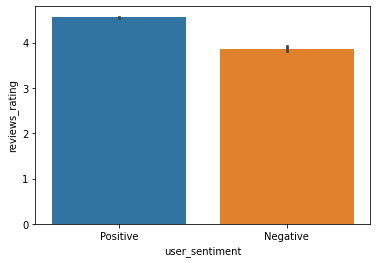

In [839]:
#Let us look at the reviews and sentinment together
import seaborn as sns
sns.barplot(data = reviews_data,x= 'user_sentiment',y='reviews_rating')

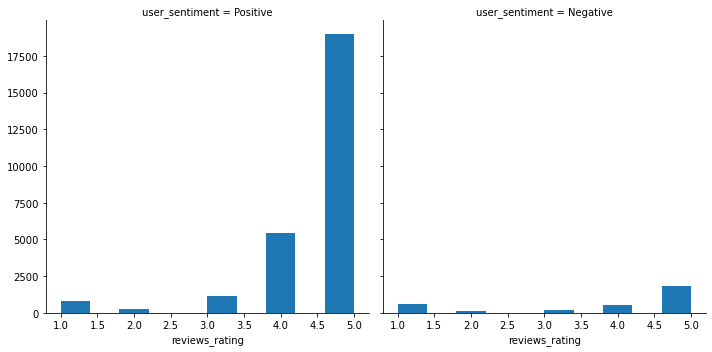

In [840]:
import seaborn as sns
g = sns.FacetGrid(reviews_data,col='user_sentiment',size=5)
g.map(plt.hist,'reviews_rating')

Looks like the there is not much difference average rating between postive and negative reviews. This needs to be investigated

In [841]:
reviews_data[(reviews_data.reviews_rating==1)&(reviews_data.user_sentiment=='Positive')]

,name,reviews_rating,reviews_text,reviews_username,user_sentiment
9,K-Y Love Sensuality Pleasure Gel,1,Got as a surprise for my husband there is noth...,moore222,Positive
11,K-Y Love Sensuality Pleasure Gel,1,Purchased this thinking it would have some sor...,bre234,Positive
14,K-Y Love Sensuality Pleasure Gel,1,First time purchase of this type of product. M...,nicole,Positive
54,Olay Regenerist Deep Hydration Regenerating Cream,1,I used (and loved) this product for several ye...,alnscoob97,Positive
56,Olay Regenerist Deep Hydration Regenerating Cream,1,I am so disappointed! I have used this product...,jacmary,Positive
...,...,...,...,...,...
28831,L'or233al Paris Elvive Extraordinary Clay Reba...,1,I'm happy I got to try this courtesy of Influe...,neighha,Positive
28832,L'or233al Paris Elvive Extraordinary Clay Reba...,1,I can see this working AMAZINGLY for someone w...,nmm2592,Positive
28833,L'or233al Paris Elvive Extraordinary Clay Reba...,1,When I got these products in the mail I was ac...,kimberlyp721,Positive
28834,L'or233al Paris Elvive Extraordinary Clay Reba...,1,I was so excited about receiving this free to ...,rachie0814,Positive


In [842]:
reviews_data[(reviews_data.reviews_rating==5)&(reviews_data.user_sentiment=='Negative')]

,name,reviews_rating,reviews_text,reviews_username,user_sentiment
211,Olay Regenerist Deep Hydration Regenerating Cream,5,this product makes my face feel like I have de...,steph710,Negative
213,Olay Regenerist Deep Hydration Regenerating Cream,5,After using a short time it totally changed th...,jojo296,Negative
215,Olay Regenerist Deep Hydration Regenerating Cream,5,I like the feel and texture of my skin after u...,beau1230,Negative
216,Olay Regenerist Deep Hydration Regenerating Cream,5,"No wrinkles for me, no worrying either because...",onectmom,Negative
217,Olay Regenerist Deep Hydration Regenerating Cream,5,This product gives my face a starry appearance...,starlady,Negative
...,...,...,...,...,...
29818,L'or233al Paris Elvive Extraordinary Clay Reba...,5,I received a complimentary sample of this prod...,cindi d,Negative
29855,L'or233al Paris Elvive Extraordinary Clay Reba...,5,This has prolonged the color in my hair! Not o...,meghanz,Negative
29858,L'or233al Paris Elvive Extraordinary Clay Reba...,5,This conditioner makes my hair very soft witho...,melissa7390,Negative
29862,L'or233al Paris Elvive Extraordinary Clay Reba...,5,This conditioner has become a staple in my hai...,kacils,Negative


__As seen there are lots of low rated products tagged as positive review and high rated products tagged as negative review. We will take the ratings to correct the sentiment tags as the reviews are given by the users themslves and hence more reliable. This can be justified by looking at the reviews and corresponding sentiments above__

In [843]:
# We will make all reviews with rating above 3 as positive and those below 3 as negative
reviews_data.loc[reviews_data.reviews_rating>3, 'user_sentiment']  ='Positive'
reviews_data.loc[reviews_data.reviews_rating<3, 'user_sentiment']  ='Negative'

<AxesSubplot:xlabel='user_sentiment', ylabel='reviews_rating'>

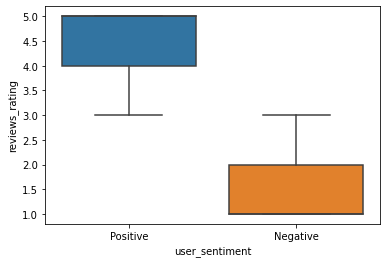

In [844]:
#let us look at the visualization agaain
import seaborn as sns
sns.boxplot(data = reviews_data,x= 'user_sentiment',y='reviews_rating')

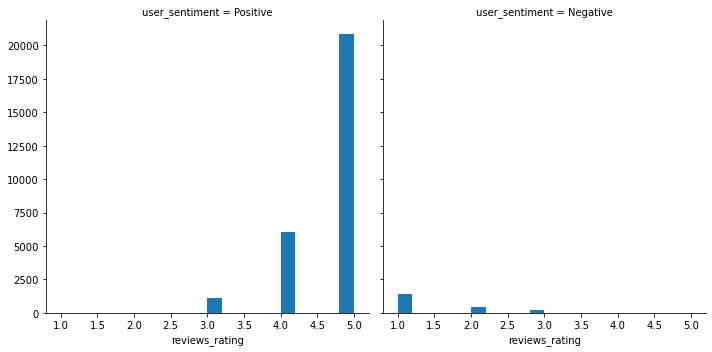

In [845]:
import seaborn as sns
g = sns.FacetGrid(reviews_data,col='user_sentiment',size=5)
g.map(plt.hist,'reviews_rating')

Beofore proceeding to mode building, we need to clean the review text colum and extarct word features for the model

In [846]:
# converting all the character to lowe case
reviews_data['reviews_text']=reviews_data['reviews_text'].str.lower()

In [847]:
# removing punctuations
reviews_data['reviews_text']=reviews_data['reviews_text'].str.replace('[^\w\s]','')

In [848]:
#removing stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
reviews_data['reviews_text'] = reviews_data['reviews_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [849]:
#getting the text feature and target sentiment
x=reviews_data['reviews_text']
y = reviews_data['user_sentiment'].map({'Positive':1,  'Negative' :0      })

In [850]:
#creating tarin and test data sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

We will use tfidf vectorizer to extarct features for the model to train

In [851]:
word_vectorizer = TfidfVectorizer(
    strip_accents='unicode',    # Remove accents and perform other character normalization during the preprocessing step. 
    analyzer='word',            # Whether the feature should be made of word or character n-grams.
    #token_pattern=r'\w{1,}',    # Regular expression denoting what constitutes a “token”, only used if analyzer == 'word'
    stop_words='english',
    max_df = 0.95,
    #min_df = 0.005,
    max_features = 15000,
    sublinear_tf=True)
word_vectorizer.fit(X_train.tolist())    # Fiting it on Train

TfidfVectorizer(max_df=0.95, max_features=15000, stop_words='english',
                strip_accents='unicode', sublinear_tf=True)

In [852]:
X_train_transformed.shape

(21000, 15000)

In [853]:
X_train.shape

(21000,)

In [854]:
#tarnsforming to training and testing features
X_train_transformed = word_vectorizer.transform(X_train.tolist())
X_test_transformed = word_vectorizer.transform(X_test.tolist())

## Model building

We will start with logistic regression on the imbalnced data and evaluate the performance

In [855]:
logit = LogisticRegression()
logit.fit(X_train_transformed,y_train)

LogisticRegression()

In [856]:
y_pred_train= logit.predict(X_train_transformed)

#Model Performance on Train Dataset
print("Logistic Regression accuracy", accuracy_score(y_pred_train, y_train))
print(classification_report(y_train,y_pred_train ))

Logistic Regression accuracy 0.9637142857142857
              precision    recall  f1-score   support

           0       0.98      0.47      0.64      1416
           1       0.96      1.00      0.98     19584

    accuracy                           0.96     21000
   macro avg       0.97      0.74      0.81     21000
weighted avg       0.96      0.96      0.96     21000



In [857]:
# Prediction Test Data
y_pred_test = logit.predict(X_test_transformed)

#Model Performance on Test Dataset
print("Logistic Regression accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_test,y_pred_test))

Logistic Regression accuracy 0.9603333333333334
              precision    recall  f1-score   support

           0       0.96      0.43      0.59       608
           1       0.96      1.00      0.98      8392

    accuracy                           0.96      9000
   macro avg       0.96      0.71      0.79      9000
weighted avg       0.96      0.96      0.95      9000



In [858]:
#confusion matrix on for the test data
confusion_matrix(y_test,y_pred_test )

array([[ 262,  346],
       [  11, 8381]], dtype=int64)

__So, the effect of class imabalnce is clearly seen on the prediction with the postive sentiments near 1 score while prediction for negative class are off__

So let us balnce the class mix by oversampling the negative class and retarin our model . We will use Synthetic Minority Oversampling from imblearn package for this

In [859]:
#oversampling the negative sentiment features
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_train_transformed_sm, y_train_sm = sm.fit_resample(X_train_transformed, y_train)

In [860]:
#buliding logistic regression for oversampled features
logit_sm = LogisticRegression()
logit_sm .fit(X_train_transformed_sm,y_train_sm)

LogisticRegression()

In [861]:
# Prediction Test Data
y_pred_test = logit_sm.predict(X_test_transformed)

#Model Performance on Test Dataset
print("Logistic Regression accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_test,y_pred_test ))

Logistic Regression accuracy 0.9417777777777778
              precision    recall  f1-score   support

           0       0.55      0.75      0.64       608
           1       0.98      0.96      0.97      8392

    accuracy                           0.94      9000
   macro avg       0.77      0.86      0.80      9000
weighted avg       0.95      0.94      0.95      9000



The model performance difference between both the classes have now come down and overall performance is betteer

Beofore we move on to build more models, let us create a custom function to evalauate model performance

In [862]:
def get_model_eval_metrics(model,  X_train, y_train, X_test, y_test):
    
    #print(X_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    roc_auc_train = roc_auc_score(y_train, y_train_pred, average='weighted')
    roc_auc_test = roc_auc_score(y_test, y_test_pred, average='weighted')
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    
    
    print('Train Metrics \n')
    
    print('Accuracy: {}'. format(model.score(X_train,y_train)))
    print('\n')
    
    print('ROC AUC Score: {}'. format(roc_auc_train))
          
    #plot_confusion_matrix(model, X_train, y_train,
                           # cmap=plt.cm.Blues)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm_train, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    title = 'AUC-ROC Score: {:.2f}'.format(roc_auc_train)
    plt.title(title)
    plt.show()
    
    
    print('\n')
    print('*****************************************************')
    
    print('Test Metrics \n')
    
    print('Accuracy: {}'. format(model.score(X_test,y_test)))
    print('\n')
    print('ROC AUC Score: {}'. format(roc_auc_test))
    print(classification_report(y_test, y_test_pred))
    print('\n')  
    plt.figure(figsize=(5,5))
    sns.heatmap(cm_test, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    title = 'AUC-ROC Score: {:.2f}'.format(roc_auc_test)
    plt.title(title)
    plt.show()

Train Metrics 

Accuracy: 0.9795241013071896


ROC AUC Score: 0.9795241013071896


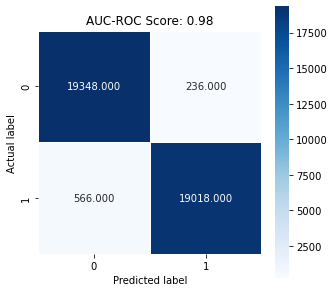



*****************************************************
Test Metrics 

Accuracy: 0.9417777777777778


ROC AUC Score: 0.8551243979228338
              precision    recall  f1-score   support

           0       0.55      0.75      0.64       608
           1       0.98      0.96      0.97      8392

    accuracy                           0.94      9000
   macro avg       0.77      0.86      0.80      9000
weighted avg       0.95      0.94      0.95      9000





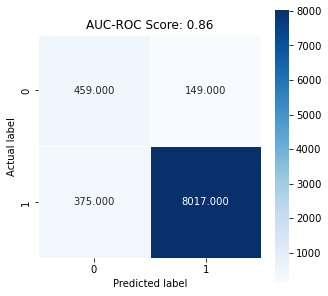

In [863]:
# Lets evaluate the logistic regression model
get_model_eval_metrics(logit_sm,X_train_transformed_sm, y_train_sm, X_test_transformed,y_test)

## Random Forest Classifier

In [864]:
# building the model
RF = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, min_samples_leaf=2)
RF.fit(X_train_transformed_sm, y_train_sm)


RandomForestClassifier(min_samples_leaf=2, n_estimators=200, n_jobs=-1,
                       random_state=42)

Train Metrics 

Accuracy: 0.9937959558823529


ROC AUC Score: 0.993795955882353


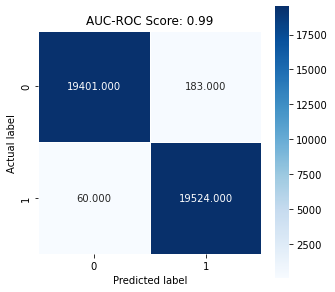



*****************************************************
Test Metrics 

Accuracy: 0.9548888888888889


ROC AUC Score: 0.8034202373187497
              precision    recall  f1-score   support

           0       0.68      0.63      0.65       608
           1       0.97      0.98      0.98      8392

    accuracy                           0.95      9000
   macro avg       0.83      0.80      0.81      9000
weighted avg       0.95      0.95      0.95      9000





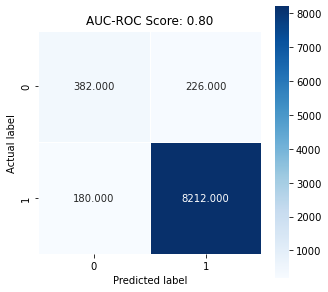

In [865]:
get_model_eval_metrics(RF,X_train_transformed_sm, y_train_sm, X_test_transformed,y_test)

## XG Boost Classifier

In [866]:
import xgboost as xgb

In [867]:
# building the model
xgb_clsfr = xgb.XGBClassifier()
xgb_clsfr.fit(X_train_transformed_sm, y_train_sm)

[19:48:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Train Metrics 

Accuracy: 0.9828176062091504


ROC AUC Score: 0.9828176062091504


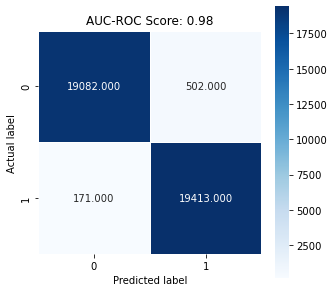



*****************************************************
Test Metrics 

Accuracy: 0.9517777777777777


ROC AUC Score: 0.7941241031558879
              precision    recall  f1-score   support

           0       0.65      0.61      0.63       608
           1       0.97      0.98      0.97      8392

    accuracy                           0.95      9000
   macro avg       0.81      0.79      0.80      9000
weighted avg       0.95      0.95      0.95      9000





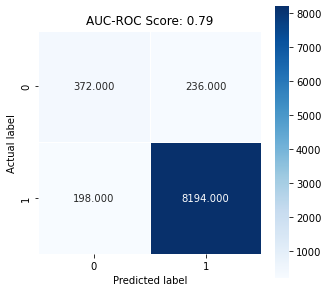

In [868]:
# Evaluating the model
get_model_eval_metrics(xgb_clsfr,  X_train_transformed_sm, y_train_sm, X_test_transformed, y_test)

## Naive Bayes

In [869]:
#building the model
from sklearn.naive_bayes import MultinomialNB

# instantiate NB class
mnb=MultinomialNB()

# fitting the model on training data
mnb.fit(X_train_transformed_sm, y_train_sm)

MultinomialNB()

Train Metrics 

Accuracy: 0.9474571078431373


ROC AUC Score: 0.9474571078431372


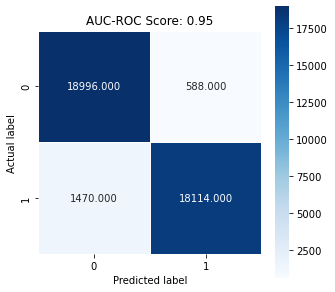



*****************************************************
Test Metrics 

Accuracy: 0.9038888888888889


ROC AUC Score: 0.8462492474035421
              precision    recall  f1-score   support

           0       0.39      0.78      0.52       608
           1       0.98      0.91      0.95      8392

    accuracy                           0.90      9000
   macro avg       0.69      0.85      0.73      9000
weighted avg       0.94      0.90      0.92      9000





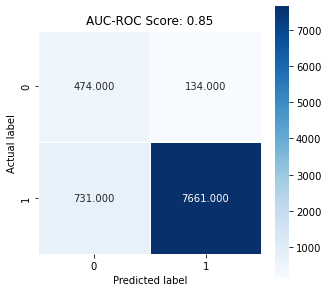

In [870]:
# Evaluating the model
get_model_eval_metrics(mnb,  X_train_transformed_sm, y_train_sm, X_test_transformed, y_test)

Looking at all the models together, it can be seen that Xgboost gives high values of recall and precison and auc score . Logistic regression gives high recall values for both the calsse but at the same time it misclassifying alot of postive reviews. So we can use Xgboost as our preferred model but let us try improve the model by hyaper paarmeter tuning

In [871]:
from sklearn.model_selection import GridSearchCV
xgb_model = xgb.XGBClassifier()

# defining hyper parameter combinations
parameters = { 'max_depth': [ 6, 8, 10],
              'n_estimators': [ 100, 300, 500]}
#creating a scorer to evaluate the performance
scorer = make_scorer(roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)
#defining the grid search model
clf_xgb = GridSearchCV(estimator=xgb_model, param_grid=parameters, 
                       #n_jobs=-1,
                                       cv=3,
                                       scoring=scorer,
                                       refit=True)



In [872]:
#executing grid search
clf_xgb.fit(X_train_transformed_sm, y_train_sm)

[19:48:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:48:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:48:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:48:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [873]:
# let us check the best model
clf_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [874]:
best_model = clf_xgb.best_estimator_

Train Metrics 

Accuracy: 0.9992595996732027


ROC AUC Score: 0.9992595996732025


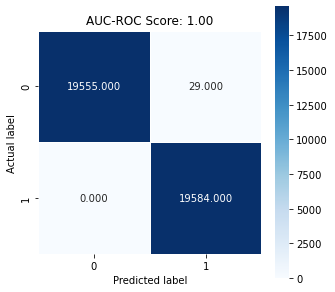



*****************************************************
Test Metrics 

Accuracy: 0.9585555555555556


ROC AUC Score: 0.8061491834328431
              precision    recall  f1-score   support

           0       0.72      0.63      0.67       608
           1       0.97      0.98      0.98      8392

    accuracy                           0.96      9000
   macro avg       0.85      0.81      0.83      9000
weighted avg       0.96      0.96      0.96      9000





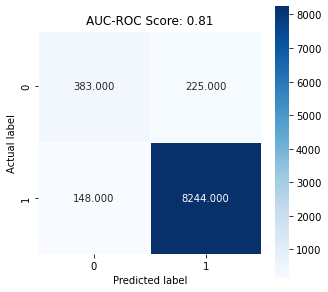

In [875]:
#evaluating the performance of the best model
get_model_eval_metrics(best_model,  X_train_transformed_sm, y_train_sm, X_test_transformed, y_test)

So,the model is looking good now with relatively higher values for all performance metrics

In [876]:
#help(confusion_matrix)

## Recommendation System

In [877]:
# First let us bring in only the required columns 
Reccom_df=reviews_data[['name','reviews_rating','reviews_username']]

In [878]:
# remove any duplicate reviews
Reccom_df=Reccom_df.drop_duplicates()

In [879]:
# We also noted in the initial EDA that there are missing values in user_name column. Let us remove these record
Reccom_df = Reccom_df[Reccom_df.reviews_username.notnull()]

In [880]:
Reccom_df.shape

(27739, 3)

In [881]:
Reccom_df.head()

,name,reviews_rating,reviews_username
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua
1,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
3,K-Y Love Sensuality Pleasure Gel,1,rebecca
4,K-Y Love Sensuality Pleasure Gel,1,walker557
5,K-Y Love Sensuality Pleasure Gel,1,samantha


In [882]:
# Creating train and test datasets for traing and evaluation
df_train, df_test= train_test_split(Reccom_df, test_size=0.3, random_state=42)

### Creating dummy train & dummy test dataset
These dataset will be used for prediction 
- Dummy train will be used later for prediction of the prodcuts which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset. 

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [883]:
# copyin the tarin datafram into dummy df first
dummy_train = df_train.copy()

In [884]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [885]:
dummy_train=dummy_train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating',
    fill_value =1 # all non rated entries made 1
)

In [886]:
# Convert the dummy train dataset into matrix format.
df_pivot=df_train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
)
df_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


__We are not normalising the rating of the products for each user around 0 mean as most of the user in the dataset rated at most one product and normalising will result in all zero rows in the matrix__

In [887]:
df_train.shape

(19417, 3)

In [888]:
df_check = df_train.groupby('reviews_username')[['name']].count()
df_check[df_check.name>1]

,name
reviews_username,
1234,2
123charlie,2
1witch,2
50cal,2
aaron,4
...,...
yvonne,2
zach,2
zipper,2


In [889]:
# Creating the User Similarity Matrix using pairwise_distance function
# this matrix gives the similarity between each user to all other user
from sklearn.metrics.pairwise import pairwise_distances
user_correlation = 1 - pairwise_distances(df_pivot.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0

## Prediction - User User

First, as we are finally going to recommend products by similar user, let us make all negative correlations to zero

In [890]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [891]:
df_pivot.fillna(0).shape

(17880, 254)

In [892]:
np.dot(df_pivot.fillna(0).iloc[17866],df_pivot.fillna(0).iloc[1])/(np.dot(df_pivot.fillna(0).iloc[17866],df_pivot.fillna(0).iloc[17866])*np.dot(df_pivot.fillna(0).iloc[1],df_pivot.fillna(0).iloc[1]))**0.5

0.0

In [893]:
np.dot(df_pivot.fillna(0).iloc[17866],df_pivot.fillna(0).iloc[17866])

25.0

In [894]:
user_correlation.shape

(17880, 17880)

Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product
rating (as present in the rating dataset).

In [895]:
#calculationg the predicted rating for each product by each user
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  5.65004633,  0.        , ...,  8.28130291,
         0.        ,  0.        ],
       [ 0.        , 24.4984009 ,  0.        , ..., 19.5975769 ,
         2.21348628,  0.        ],
       ...,
       [ 0.        ,  6.13455206,  0.        , ..., 16.89852672,
         0.        ,  0.        ],
       [ 0.        ,  6.13455206,  0.        , ..., 16.89852672,
         0.        ,  0.        ],
       [ 0.        ,  0.79418644,  0.        , ...,  8.65937016,
         5.37692342,  0.        ]])

In [896]:
user_predicted_ratings.shape

(17880, 254)

In [897]:
dummy_train.shape

(17880, 254)

Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero.

In [898]:
user_final_rating = multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
00sab00,0.0,5.650046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.281728,...,0.0,0.0,0.000000,1.111812,0.0,0.0,0.0,8.281303,0.000000,0.0
01impala,0.0,24.498401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.249002,...,0.0,0.0,2.527452,1.429472,0.0,0.0,0.0,19.597577,2.213486,0.0
02dakota,0.0,24.498401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.249002,...,0.0,0.0,2.527452,1.429472,0.0,0.0,0.0,19.597577,2.213486,0.0
02deuce,0.0,24.498401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.249002,...,0.0,0.0,2.527452,1.429472,0.0,0.0,0.0,19.597577,2.213486,0.0


In [899]:
#let us check the top 2p products for user 'nmm2592'
d = user_final_rating.loc['nmm2592'].sort_values(ascending=False)[0:20]
d.index

Index(['Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
       'Burt's Bees Lip Shimmer, Raisin', 'Red (special Edition) (dvdvideo)',
       'Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd',
       'Physicians Formula Powder Palette Mineral Glow Pearls, Translucent Pearl',
       'Plano Mini-Magnum 13-Compartment Tackle Box',
       'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
       'Pink Friday: Roman Reloaded Re-Up (w/dvd)',
       'Pinaud Clubman Styling Gel, Superhold',
       '0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest',
       'Physicians Formula Mineral Wear Talc-Free Mineral Correcting Powder, Creamy Natural',
       'Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black',
       'Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack',
       'Pearhead Id Bracelet Frame',
       'Pantene Pro-V Expert Collection Age Defy Conditioner',
       'Pantene Color Preserve Volume Shampoo, 25

In [900]:
# checking the product originally reviewd by iser 'nmm2592'
df_train[df_train.reviews_username=='nmm2592']

,name,reviews_rating,reviews_username
28822,L'or233al Paris Elvive Extraordinary Clay Reba...,1,nmm2592


## Evaluation

We will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user. 

In [901]:
# Find out the common users of test and train dataset.
common = df_test[df_test.reviews_username.isin(df_train.reviews_username)]
common.head()

,name,reviews_rating,reviews_username
21524,Nexxus Exxtra Gel Style Creation Sculptor,1,tony1
19216,Clorox Disinfecting Bathroom Cleaner,5,chinarachel
4074,"Pendaflex174 Divide It Up File Folder, Multi S...",5,shelia
3080,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,5,lady
25883,Godzilla 3d Includes Digital Copy Ultraviolet ...,5,striker


In [902]:
len(common.reviews_username.unique())

922

Now just like we did during predicting, let us create the user correlation matrix and predict the rating for the product already rated by the user

In [903]:
# creating commn user X product matrix data set
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')
common_user_based_matrix

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),Ambi Complexion Cleansing Bar,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter","BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Tresemme Kertatin Smooth Infusing Conditioning,Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37f5p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.87E+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
woody,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
woowoo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xmom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we will filter the user correlation matrix we created earlier for the common users 

In [904]:
# first convert the correlation matrix to a dataframe
user_correlation_df = pd.DataFrame(user_correlation, index= df_pivot.index, columns =df_pivot.index.tolist())

In [905]:
user_correlation_df.head()

,00dog3,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1085,...,zpalma,zsarah,zsazsa,zt313,zubb,zulaa118,zwithanx,zxcsdfd,zxjki,zzdiane
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [906]:
#filter for the dataframe for common users
user_correlation_df_common = user_correlation_df.loc[common.reviews_username.unique(),common.reviews_username.unique()]
user_correlation_df_common

,tony1,chinarachel,shelia,lady,striker,meme,jason,great,doris60,shannon,...,acv4217,nmal,toni,deborah,donnamax,mustang,court,kendy,deb,arlingtondonna
reviews_username,,,,,,,,,,,,,,,,,,,,,
tony1,1.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,1.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
chinarachel,0.0,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.0,...,0.0,0.0,0.000000,0.0,1.000000,0.0,0.707107,0.0,0.0,1.000000
shelia,0.0,0.000000,1.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
lady,0.0,0.000000,0.0,1.0,0.0,0.000000,0.529813,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
striker,0.0,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mustang,0.0,0.000000,0.0,0.0,0.0,0.000000,0.662266,0.0,0.000000,0.0,...,0.0,0.0,0.707107,0.0,0.000000,1.0,0.000000,0.0,0.0,0.000000
court,0.0,0.707107,0.0,0.0,0.0,0.685994,0.000000,0.0,0.707107,0.0,...,0.0,0.0,0.000000,0.0,0.707107,0.0,1.000000,0.0,0.0,0.707107
kendy,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.000000


In [907]:
# only using positive correlations as before
user_correlation_df_common[user_correlation_df_common<0]=0
# prediction for already rated products as correlation-weighted sum of ratings
common_user_predicted_ratings = np.dot(user_correlation_df_common, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[ 2.46182982,  2.88675135,  0.        , ...,  3.56928265,
         0.        ,  0.        ],
       [22.53553391,  5.        ,  0.        , ..., 28.53553391,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [13.53553391,  4.        ,  0.        , ..., 15.48836757,
         0.        ,  4.        ],
       [ 0.        ,  4.3519414 ,  0.        , ...,  1.23895876,
         0.        ,  0.        ],
       [22.53553391,  5.        ,  0.        , ..., 28.53553391,
         0.        ,  0.        ]])

Let us now create the dummy test matrix for common users to get the rating for only rated products 

In [908]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating',fill_value=0)

In [909]:
# final prediction on for only alredy rated products
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

Now we will use RMSE to evaluate the ratings. For this first lets normalise all the predicted ratings between 1 and 5

In [910]:
from sklearn.preprocessing import MinMaxScaler

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [911]:
#calculationg total predicted items by all the common user
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

1126

In [912]:
# calculationg RMSE
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.5022963394274806


## ITEM BAESD

The approach here is similar, but we take the product X user matrix to get the rating matrix

In [913]:
df_pivot=df_train.pivot_table(
    index='name', # index now is product
    columns='reviews_username', # column now is username
    values='reviews_rating'
)
df_pivot.head()

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1085,...,zpalma,zsarah,zsazsa,zt313,zubb,zulaa118,zwithanx,zxcsdfd,zxjki,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here we normalize the rating for each product around the mean as a product is rated by a lot of users

In [914]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1085,...,zpalma,zsarah,zsazsa,zt313,zubb,zulaa118,zwithanx,zxcsdfd,zxjki,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.323529,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [915]:
# creating item correlation matrix using cosine similarity
item_correlation = 1-pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [916]:
# making negative correltions to zero if any as we are looking for positively corrleated items
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [917]:
# predicting the rating for all products
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00451401, 0.        , ..., 0.00259548, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.008666  , 0.00385341,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00089839, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00035935, 0.        ,
        0.        ],
       [0.        , 0.03357542, 0.        , ..., 0.01684124, 0.00747106,
        0.        ]])

In [918]:
#Filtering the rating only for the products not rated by the user for recommendation
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
00sab00,0.0,0.004514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.002595,0.000000,0.0
01impala,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.004130,0.001511,0.0,0.0,0.0,0.008666,0.003853,0.0
02dakota,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.006883,0.002519,0.0,0.0,0.0,0.014443,0.006422,0.0
02deuce,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.005507,0.002015,0.0,0.0,0.0,0.011555,0.005138,0.0


In [919]:
# checking the top 20 recommended items for user 'nmm2592' 
d = item_final_rating.loc['nmm2592'].sort_values(ascending=False)[0:20]
d.index.tolist()

['Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'Red (special Edition) (dvdvideo)',
 "Burt's Bees Lip Shimmer, Raisin",
 'Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd',
 'Physicians Formula Powder Palette Mineral Glow Pearls, Translucent Pearl',
 'Plano Mini-Magnum 13-Compartment Tackle Box',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 'Pink Friday: Roman Reloaded Re-Up (w/dvd)',
 'Pinaud Clubman Styling Gel, Superhold',
 '0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest',
 'Physicians Formula Mineral Wear Talc-Free Mineral Correcting Powder, Creamy Natural',
 'Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black',
 'Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack',
 'Pearhead Id Bracelet Frame',
 'Pantene Pro-V Expert Collection Age Defy Conditioner',
 'Pantene Color Preserve Volume Shampoo, 25.4oz',
 'Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Medium, LWS-127201',

## Evaluation

Evaluation follows similar steps as we did for user based

In [920]:
# Find out the common products of test and train dataset.
common =  df_test[df_test.name.isin(df_train.name)]
common.shape

(8303, 3)

In [921]:
# creating product X user matrix 
common_item_based_matrix = common.pivot_table(index='name', columns='reviews_username', values='reviews_rating')

In [922]:
# creating item correlation dataframe
item_correlation_df = pd.DataFrame(item_correlation, index= df_subtracted.index, columns =df_subtracted.index.tolist())
item_correlation_df.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [923]:
# filtering item correlation for only commmon products
item_correlation_df_common = item_correlation_df.loc[common.name.unique(),common.name.unique()]
item_correlation_df_common.head()

,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Nexxus Exxtra Gel Style Creation Sculptor,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,Olay Regenerist Deep Hydration Regenerating Cream,Mike Dave Need Wedding Dates (dvd + Digital),Bisquick Original Pancake And Baking Mix - 40oz,"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",...,Coola Organic Sunscreen Classic Face Cucumber SPF 30,Honeywell Heatbud Ceramic Heater Black,Bedtime Originals Pinkie Musical Mobile,Stacy's Garden Veggie Medley Pita Chips,Solo Foods Poppy Seed Cake and Pastry Filling,"Smead174 2 1/4 Inch Accordion Expansion Wallet, Poly, Letter, Translucent Green","Smead174 3-In-1 Supertab Section Folders, 1/3 Cut Top Tab, Letter, Assorted, 12/pack",Nature's Path Chunky Chocolate Peanut Chewy Granola Bars,Stander Pt Bedcane - Bed Handle,"Kikkoman Soy Sauce, 5fl oz"
name,,,,,,,,,,,,,,,,,,,,,
Clorox Disinfecting Bathroom Cleaner,1.000000,0.168685,0.000000,0.000170,0.000000,0.000383,0.001025,0.000415,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,0.168685,1.000000,0.000461,0.001309,0.005387,0.000000,0.000064,0.000264,0.0,0.001583,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nexxus Exxtra Gel Style Creation Sculptor,0.000000,0.000461,1.000000,0.000173,0.000000,0.000831,0.000000,0.009155,0.0,0.002131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,0.000170,0.001309,0.000173,1.000000,0.000642,0.000533,0.000000,0.001595,0.0,0.001195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,0.000000,0.005387,0.000000,0.000642,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [924]:
# predicting rating for all products
item_correlation_df_common[item_correlation_df_common<0]=0
common_item_predicted_ratings = np.dot(item_correlation_df_common, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Let us now create the dummy test matrix for common users to get the rating for only rated products 

In [925]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='name', columns='reviews_username', values='reviews_rating').fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [926]:
common_item_predicted_ratings

reviews_username,00sab00,1.11E+24,11111111aaaaaaaaaaaaaaaaa,1234,1234asdf,123numbers,123soccermom,123too,12gage,13dani,...,zombiegirl22,zombiejess,zombiekiller,zoney86,zoso60,zowie,zozo0o,zuttle,zyiah4,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Africa's Best No-Lye Dual Conditioning Relaxer System Super,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Weleda Everon Lip Balm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we will use RMSE to evaluate the ratings. For this first lets normalise all the predicted ratings between 1 and 5

In [927]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [928]:
# Finding total non-NaN value
#calculationg total predicted items by all the common user
common_ = common.pivot_table(index='name', columns='reviews_username', values='reviews_rating')
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.684019525250815


The performance of item based filtering is not good as that of User based filtering. So, we will be using user based approach in our final model 